# AA tests

## Goal: 

>**1. Does the holiday season greatly affect the results?**

>**2. Are the sampling process random?**



It is not ideal to test either control/experiment group directly with other group as the data in other group is not indepedent of the experiment/control group. 

It is more appropriate to test the change in the user behavior in time. 

For this purpose, we need to separate the other group into `other_exp group` and `other_con` group.



The experiment time is from `2017-12-12 00:00:00` to `2018-01-08 23:59:59`.

The rest of the time is the non-experiment time. 


## Group assignment 


`Experiment group`: in experiment time, id starts with either ("b","c","e","f","5").

`Control group`: in experiment time, id **doesn't** start with ("b","c","e","f","5").
 
`other_exp group`: not in experiment time, id starts with ("b","c","e","f","5")

`other_con group`: not in experiment time, id **doesn't** start with ("b","c","e","f","5")

In [1]:
import pandas as pd
from scipy.stats import ttest_rel
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
analytics = pd.read_csv("./data/clean_analytics.csv")

In [3]:
analytics['time_used'] = analytics['event_end'] - analytics['event_start']

In [4]:
analytics['assignment'].value_counts()

Other         148380
Control       111963
Experiment     52450
Name: assignment, dtype: int64

In [5]:
def id_group_assign(user_id):
    char = user_id[0]
    if char in ("b","c","e","f","5"):
        result = "Experiment"
    elif char not in ("b","c","e","f","5"):
        result = "Control"
        
    return result


def time_group_assign(unix_time, lower = 1513036800 ,upper = 1515455999):
    if lower <= unix_time <= upper:
        result = "Experiment"
    elif unix_time > upper or unix_time < lower:
        result = "Control"
        
    return result

In [6]:
analytics['id_assign'] = analytics['user_B'].apply(id_group_assign)

analytics['time_assign'] = analytics['event_start'].apply(time_group_assign)

In [7]:
analytics.head()

,user_A,user_B,event_start,event_end,assignment,time_used,id_assign,time_assign
0,c8501e4e-7914-411b-9d0c-96a3180d0daa,4380277a-5cb8-42d7-8b21-2a7daba6906f,1.516901e+09,1.516907e+09,Other,6251.0,Control,Control
1,1b906005-3fc7-44df-a93f-cc7afdf11bd4,6427b7f4-9223-4bfb-8d9b-e19abeeb387e,1.516901e+09,NaN,Other,NaN,Control,Control
2,36cbbb08-5794-43f2-92d1-c6313ac355f8,c8270f60-5ce2-4df0-9487-eb6fd1ca2369,1.516814e+09,1.516901e+09,Other,87191.0,Experiment,Control
3,329d3d52-ce78-4d3a-8a91-f765a31e0319,5d1a38a1-39ce-4640-8c3c-bb010e9a64ab,1.514399e+09,1.514410e+09,Experiment,10966.0,Experiment,Experiment
4,82f959c6-559d-4d51-8323-0c41a0741f4a,de77a7b7-b2af-4738-9d3b-4948d23f0f57,1.514410e+09,1.514739e+09,Control,329044.0,Control,Experiment


## Hypothesis testing 1

> What is the effect of Holliday season on proportion of mutual relationships formed?

The `control group` and `other_con group` data will be used here. 

1. Define `p1` to be the percentage of users that formed a mutual relationship in the `control` group. 

2. Define `p2` to be the percentage of users that formed a mutual relationship in the `other_con` group.

`Null hypothesis: p1 and p2 are independent of the group split (p1 = p2)`

`Alternative hypothesis: p1 and p2 are not independent of the group split (p1 not equal p2)`

The type-I error rate is set to a standard 5%. 

`Chi-squared test` used.


In [8]:
control_id_index = analytics['id_assign'] == "Control"

control_time_index = analytics['time_assign'] == "Control"
exp_time_index = analytics['time_assign'] == "Experiment"

na_time_index = analytics['event_end'].isna()

notna_time_index = analytics['event_end'].notna()

In [9]:
control_id_data = analytics[control_id_index].copy()

In [10]:
control_time_mutual = control_id_data.loc[control_time_index & notna_time_index].shape[0]
control_time_none = control_id_data.loc[control_time_index & na_time_index].shape[0]

exp_time_mutual = control_id_data.loc[exp_time_index & notna_time_index].shape[0]
exp_time_none = control_id_data.loc[exp_time_index & na_time_index].shape[0]

In [11]:
obs = [[control_time_mutual,control_time_none ],[exp_time_mutual, exp_time_none]]

In [12]:
obs

[[43833, 57777], [59449, 52514]]

In [13]:
chi2, p, dof, ex = chi2_contingency(obs, correction=True)

In [14]:
p

0.0

### The p-value for this independence test is  smaller than 0.05.

**The null hypothesis is rejected.**

There is a significant difference between the proportions of people that formed a mutual relationship in experiment(Holiday) time  and non-experiment(non-Holiday) time.

In [49]:
control_time_percentage = control_time_mutual/ (control_time_mutual + control_time_none)
control_time_percentage

0.4313847062297018

In [16]:
exp_time_percentage = exp_time_mutual/(exp_time_mutual + exp_time_none)
exp_time_percentage

0.5309700526066647

The other_con group has `43.13%` of users that formed the mutual relationship, while the control group has a `53.09%` of users that formed the mutual relationship. 

In [17]:
(exp_time_percentage - control_time_percentage )/ control_time_percentage

0.2308504333575891

## Holiday season has a great effect on the proportions of people that forms a mutual relationship (23.08% increase).

## Hypothesis testing 2

> What is the effect of Holliday season on the median time take to form a mutual relationship?

The `control group` and `other_con group` data will be used here. 


`Null hypothesis: The distribution of time used in forming a mutual relationship is the same for control and other_con group. `

`Alternative hypothesis:  The distribution of time used in forming a mutual relationship is not the same for control and other_con group. `

The type-I error rate is set to a standard 5%. 

The `Wilcoxon rank-sum test` will be used here. 

In [18]:
control_id_index = analytics['id_assign'] == "Control"

control_id_data = analytics[control_id_index].copy()

In [19]:
control_time_index = analytics['time_assign'] == "Control"
exp_time_index = analytics['time_assign'] == "Experiment"

notna_time_index = analytics['event_end'].notna()

In [20]:
experitment_time = control_id_data.loc[exp_time_index & notna_time_index, "time_used"].values
control_time = control_id_data.loc[control_time_index & notna_time_index, "time_used"].values

In [21]:
stats, p = mannwhitneyu(experitment_time, control_time, alternative = "two-sided")

In [22]:
p

3.6988623080962823e-135

### The p-value for this test is  much smaller than 0.05.

**The null hypothesis is rejected.**

The median value for the control group and the other_con group is different. 

In [23]:
np.median(experitment_time)

53905.0

In [24]:
np.median(control_time)

34621.0

In [25]:
(np.median(experitment_time) - np.median(control_time) )/np.median(control_time)

0.55700297507293262

## There is a 55% increase in median time used to form a mutual relationship in holiday season compared to the non-Holiday season.

## Hypothesis testing 3

> Is the sampling process random?


The `other_exp group` and `other_con group` data will be used here. 

1. Define `p1` to be the percentage of users that formed a mutual relationship in the other_exp group. 

2. Define `p2` to be the percentage of users that formed a mutual relationship in the other_con group.

`Null hypothesis: p1 and p2 are independent of the group split (p1 = p2)`

`Alternative hypothesis: p1 and p2 are not independent of the group split (p1 not equal p2)`

The type-I error rate is set to a standard 5%. 

`Chi-squared test` used.

In [26]:
control_time_index = analytics['time_assign'] == "Control"

control_id_index = analytics['id_assign'] == "Control"
exp_id_index = analytics['id_assign'] == "Experiment"

na_time_index = analytics['event_end'].isna()

notna_time_index = analytics['event_end'].notna()

In [27]:
control_time_data = analytics[control_time_index].copy()

In [28]:
control_id_mutual = control_time_data.loc[control_id_index & notna_time_index].shape[0]
control_id_none = control_time_data.loc[control_id_index & na_time_index].shape[0]

exp_id_mutual = control_time_data.loc[exp_id_index & notna_time_index].shape[0]
exp_id_none = control_time_data.loc[exp_id_index & na_time_index].shape[0]

In [29]:
obs = [[control_id_mutual,control_id_none ],[exp_id_mutual, exp_id_none]]

In [30]:
obs

[[43833, 57777], [20860, 25910]]

In [31]:
chi2, p, dof, ex = chi2_contingency(obs, correction=True)

In [32]:
p

1.3388928977539721e-07

### The p-value for this test is  smaller than 0.05.

**The null hypothesis is rejected.**

There is a significant difference between the proportions of people that formed a mutual relationship in non-experiment time for users whose id starts with ("b","c","e","f","5") and users whose id doesn't start with ("b","c","e","f","5"). 

This implies that there is an inherent difference in proportions of people that formed a mutual relationship in the experiment and control group in non-experiment time. 

In [33]:
control_id_percentage = control_id_mutual/(control_id_mutual + control_id_none)
control_id_percentage

0.4313847062297018

In [34]:
exp_id_percentage = exp_id_mutual/(exp_id_mutual + exp_id_none)
exp_id_percentage

0.44601240111182383

## A further look into the actual difference in proportions indicates that the difference is small compared to other effects. 

## Hypothesis testing 4 

> Is the sampling process random?


Define `t1` to be the time used for a user in `other_con group` to form a mutual relationship.

Define `t2` to be the time used for a user in `other_exp group` to form a mutual relationship. 

`Null hypothesis: The distribution of time used in forming a mutual relationship is the same for other_exp and other_con group. `

`Alternative hypothesis:  The distribution of time used in forming a mutual relationship is not the same for other_exp and other_con group. `

The type-I error rate is set to a standard 5%. 

The `Wilcoxon rank-sum test` will be used here. 

In [35]:
control_time_index = analytics['time_assign'] == "Control"

control_time_data = analytics[control_time_index].copy()

In [36]:
control_id_index = analytics['id_assign'] == "Control"
exp_id_index = analytics['id_assign'] == "Experiment"

notna_time_index = analytics['event_end'].notna()

In [37]:
experiment_time = control_time_data.loc[exp_id_index & notna_time_index, "time_used"].values

control_time = control_time_data.loc[control_id_index & notna_time_index, "time_used"].values

In [38]:
stats, p = mannwhitneyu(experiment_time, control_time, alternative = "two-sided")

In [39]:
p

0.75175229184718306

### The p-value for this test is larger than 0.05.

**Fail to reject the null hypothesis.**

The median time used for forming the mutual relationships for the other_exp group and the other_con group is the same. 

There is no difference in the median time used to form a mutual relationship in both groups.  

## In conclusion, the sampling process is random.

## More questions: 
1. Could the results be affected given the data is both right censored and left censored? 
2. Does the number of push notifications affect the the proportions of mutual relationship formation and the time used for forming a mutual relationship? 

In [40]:
import pandas as pd
import numpy as np

In [41]:
analytics = pd.read_csv("./data/clean_analytics.csv")

analytics['time_used'] = analytics['event_end'] - analytics['event_start']

## 1. Could the results be affected given the data is both right censored and left censored? 


In [42]:
analytics['event_end'].max() - analytics['event_start'].min()

5356776.0

In [43]:
np.median(analytics.loc[analytics['time_used'].notna(),'time_used'])

44049.0

The total amount of time spent in the study is 5356776 seconds, which is much larger than the median of 44049 seconds. The effect of censoring is minimal. 

## 2. Does the number of push notifications affect the time used for forming a mutual relationship?

In [44]:
count_timeused = analytics[(analytics.event_end.notna()) & (analytics.assignment == "Experiment")]\
.groupby("user_B").agg({"time_used":'median',"event_start":"count"})[["time_used","event_start"]]

In [45]:
count_timeused.columns = ['time_used',"num_relations"]

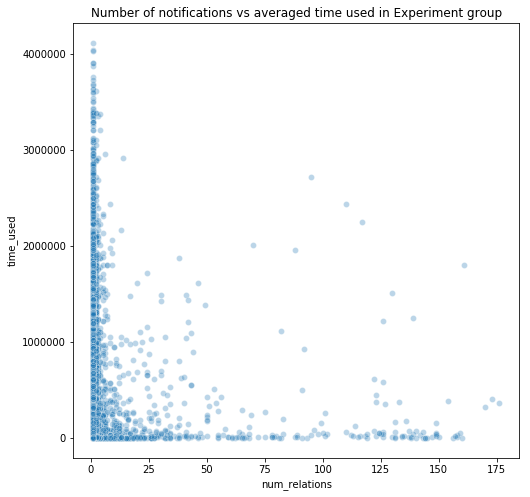

In [46]:
plt.figure(figsize = (8,8))
sns.scatterplot(x = "num_relations", y= "time_used", data = count_timeused, alpha = 0.3)
plt.title("Number of notifications vs averaged time used in Experiment group");

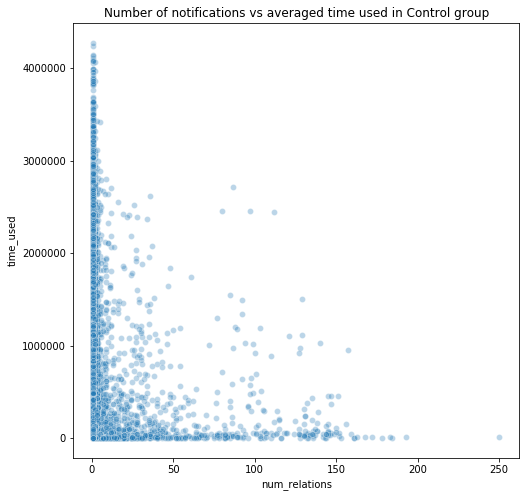

In [47]:
count_timeused = analytics[(analytics.event_end.notna()) & (analytics.assignment == "Control")]\
.groupby("user_B").agg({"time_used":'median',"event_start":"count"})[["time_used","event_start"]]

count_timeused.columns = ['time_used',"num_relations"]

plt.figure(figsize = (8,8))
sns.scatterplot(x = "num_relations", y= "time_used", data = count_timeused, alpha = 0.3)
plt.title("Number of notifications vs averaged time used in Control group");

## A further analysis is needed to understand the relationship between number of notifications and the time used to form a mutual relationship. 